In [1]:
import sys
import os

# Get the current working directory (e.g., .../Optimization_Project/notebooks)
current_dir = os.getcwd()

# Get the parent directory (e.g., .../Optimization_Project/)
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    print(f"Added '{parent_dir}' to sys.path")

Added 'd:\Resume_Project\Optimization' to sys.path


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Import base classes and helpers
from utils.base import Function
from utils.plot_helpers import plot_loss_curves, plot_contour_comparison

# Import test functions
from utils.test_functions import (
    Rosenbrock, 
    Quadratic, 
    generate_linear_regression_data, 
    linear_regression_loss, 
    linear_regression_gradient
)

# Import the optimizers we are testing
from optimizers.momentum import (
    MomentumGradientDescent,
    NesterovGradientDescent
)

# Magic command for plotting
%matplotlib inline

## 1. Contour Plot: Momentum Methods on Rosenbrock

This plot compares the optimization paths of standard `Momentum Gradient Descent` and `Nesterov Accelerated Gradient` on the 2D Rosenbrock function.

Momentum-based methods add a velocity term that accumulates past gradients, helping to:
- Build speed in consistent directions
- Smooth out oscillations
- Navigate through narrow valleys more efficiently

Nesterov's variant improves on standard momentum by computing gradients at a "look-ahead" position, allowing for more responsive corrections.

Running Momentum Gradient Descent...
Found solution: [1.00000112 1.00000228] in 3155 iterations.

Running Nesterov Accelerated Gradient...
Found solution: [1.00000111 1.00000227] in 3045 iterations.



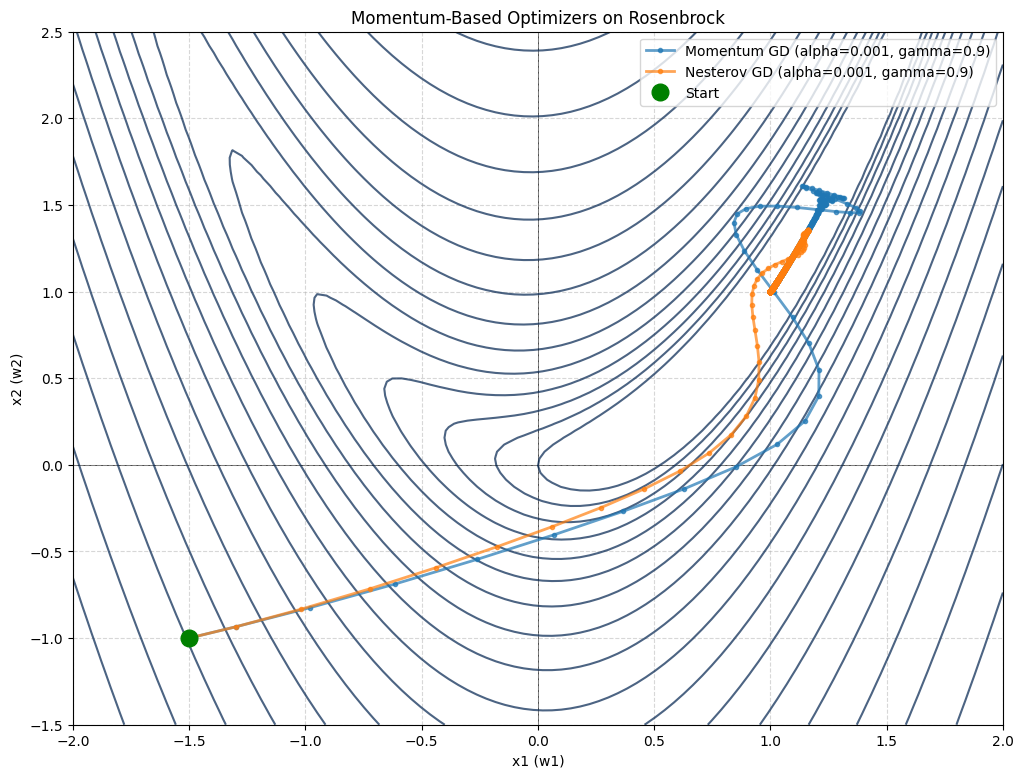

In [3]:
# --- 1. Define Optimizers ---
momentum_gd = MomentumGradientDescent(alpha=0.001, gamma=0.9)
nesterov_gd = NesterovGradientDescent(alpha=0.001, gamma=0.9)

# --- 2. Define Problem ---
start_point = np.array([-1.5, -1.0])

# --- 3. Run Optimizations ---
print("Running Momentum Gradient Descent...")
sol_mgd, history_mgd = momentum_gd.optimize(
    x=start_point.copy(),
    func_callback=Rosenbrock,
    grad_func_callback=Rosenbrock.grad,
    hessian_func_callback=Rosenbrock.hessian,
    is_plot=True 
)
print(f"Found solution: {sol_mgd} in {momentum_gd.num_iter} iterations.\n")

print("Running Nesterov Accelerated Gradient...")
sol_nag, history_nag = nesterov_gd.optimize(
    x=start_point.copy(),
    func_callback=Rosenbrock,
    grad_func_callback=Rosenbrock.grad,
    hessian_func_callback=Rosenbrock.hessian,
    is_plot=True
)
print(f"Found solution: {sol_nag} in {nesterov_gd.num_iter} iterations.\n")

# --- 4. Plot Comparison ---
plot_contour_comparison(
    func_callable=Rosenbrock,
    histories={
        "Momentum GD (alpha=0.001, gamma=0.9)": history_mgd,
        "Nesterov GD (alpha=0.001, gamma=0.9)": history_nag
    },
    x_range=(-2, 2),
    y_range=(-1.5, 2.5),
    title="Momentum-Based Optimizers on Rosenbrock"
)

## 2. Contour Plot: Momentum Methods on Quadratic Function

Let's test the momentum methods on a simpler quadratic function to see how they handle a smoother optimization landscape.

Running Momentum GD on Quadratic...
Found solution: [-1.90605947e-07 -1.90605947e-07] in 249 iterations.

Running Nesterov GD on Quadratic...
Found solution: [-9.68976922e-08 -9.68976922e-08] in 92 iterations.



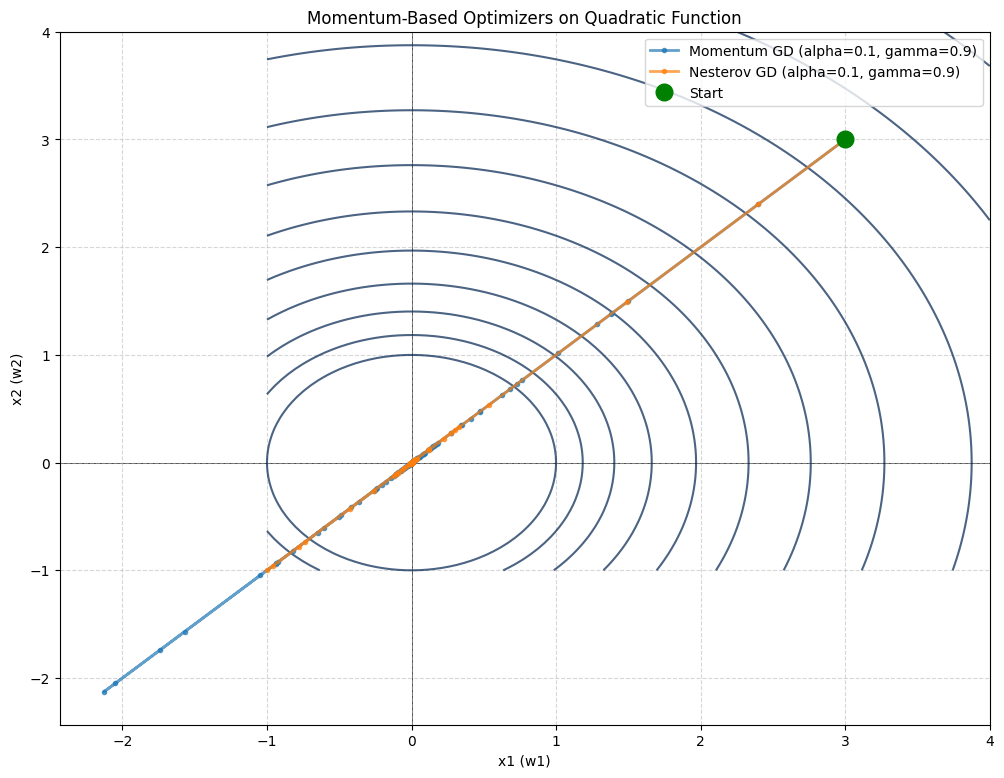

In [4]:
# --- 1. Define Optimizers ---
momentum_gd_quad = MomentumGradientDescent(alpha=0.1, gamma=0.9)
nesterov_gd_quad = NesterovGradientDescent(alpha=0.1, gamma=0.9)

# --- 2. Define Problem ---
start_point_quad = np.array([3.0, 3.0])

# --- 3. Run Optimizations ---
print("Running Momentum GD on Quadratic...")
sol_mgd_quad, history_mgd_quad = momentum_gd_quad.optimize(
    x=start_point_quad.copy(),
    func_callback=Quadratic,
    grad_func_callback=Quadratic.grad,
    hessian_func_callback=Quadratic.hessian,
    is_plot=True
)
print(f"Found solution: {sol_mgd_quad} in {momentum_gd_quad.num_iter} iterations.\n")

print("Running Nesterov GD on Quadratic...")
sol_nag_quad, history_nag_quad = nesterov_gd_quad.optimize(
    x=start_point_quad.copy(),
    func_callback=Quadratic,
    grad_func_callback=Quadratic.grad,
    hessian_func_callback=Quadratic.hessian,
    is_plot=True
)
print(f"Found solution: {sol_nag_quad} in {nesterov_gd_quad.num_iter} iterations.\n")

# --- 4. Plot Comparison ---
plot_contour_comparison(
    func_callable=Quadratic,
    histories={
        "Momentum GD (alpha=0.1, gamma=0.9)": history_mgd_quad,
        "Nesterov GD (alpha=0.1, gamma=0.9)": history_nag_quad
    },
    x_range=(-1, 4),
    y_range=(-1, 4),
    title="Momentum-Based Optimizers on Quadratic Function"
)

## 3. Application: Momentum Methods on Linear Regression

This section compares the convergence speed of momentum-based optimizers on our linear regression problem. 

We'll see how momentum helps accelerate convergence compared to standard gradient descent.

In [5]:
# --- 1. Generate Data ---
N = 200  # Number of data points
d = 1    # Number of features
X_aug, Y, W_true = generate_linear_regression_data(N=N, d=d)

print(f"Data shape (X_aug): {X_aug.shape}")
print(f"Data shape (Y): {Y.shape}")
print(f"True weights (W_true): \n{W_true}\n")

# --- 2. Define Initial Weights ---
W_initial_2D = np.random.randn(d + 1, 1)
W_initial_1D = W_initial_2D.flatten() 
print(f"Initial weights (W_initial): \n{W_initial_2D}\n")

# --- 3. Setup Callbacks for Optimizers ---
def batch_loss_wrapper(W_1D):
    W_2D = W_1D.reshape(-1, 1)
    return linear_regression_loss(W_2D, X_aug, Y)

def batch_grad_wrapper(W_1D):
    W_2D = W_1D.reshape(-1, 1)
    return linear_regression_gradient(W_2D, X_aug, Y).flatten()

# Create the Function object
linear_reg_func = Function(
    func=batch_loss_wrapper,
    grad_func=batch_grad_wrapper,
    name="Linear Regression MSE"
)

# --- 4. Setup for Plotting ---
def final_loss_plotter(W):
    W_2D = W.reshape(-1, 1)
    return linear_regression_loss(W_2D, X_aug, Y)

Data shape (X_aug): (200, 2)
Data shape (Y): (200, 1)
True weights (W_true): 
[[1.42699464]
 [0.72057148]]

Initial weights (W_initial): 
[[0.0286575 ]
 [0.59984131]]



Running Momentum GD on Linear Regression...
Momentum GD done in 1436 iterations.
Final weights: [[1.371608  ]
 [0.77639726]]

Running Nesterov GD on Linear Regression...
Nesterov GD done in 1447 iterations.
Final weights: [[1.37160805]
 [0.77639717]]

Generating loss curve comparison...


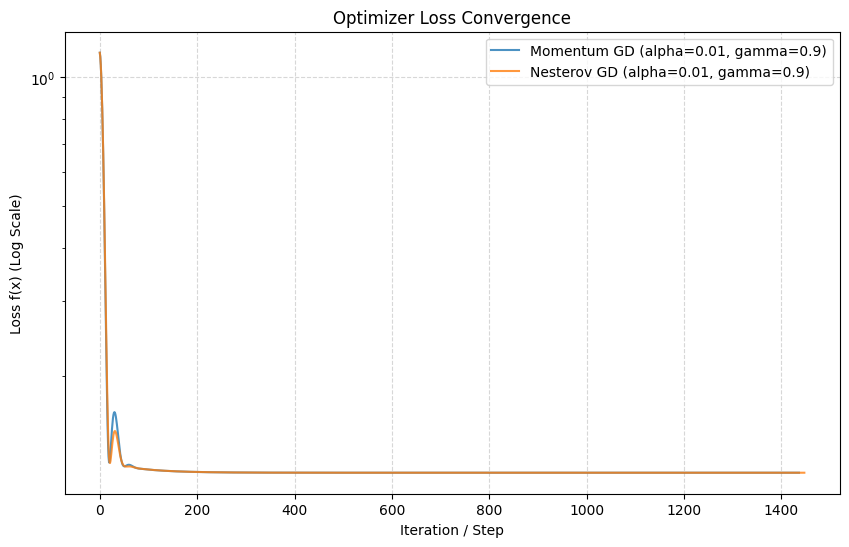

In [7]:
# --- 1. Instantiate Optimizers ---
momentum_gd_lr = MomentumGradientDescent(alpha=0.01, gamma=0.9)
nesterov_gd_lr = NesterovGradientDescent(alpha=0.01, gamma=0.9)

# --- 2. Run Optimizers ---
print("Running Momentum GD on Linear Regression...")
sol_mgd_lr, hist_mgd_lr = momentum_gd_lr.optimize(
    x=W_initial_1D.copy(),
    func_callback=linear_reg_func,
    grad_func_callback=linear_reg_func.grad,
    is_plot=True
)
print(f"Momentum GD done in {momentum_gd_lr.num_iter} iterations.")
print(f"Final weights: {sol_mgd_lr.reshape(-1, 1)}\n")

print("Running Nesterov GD on Linear Regression...")
sol_nag_lr, hist_nag_lr = nesterov_gd_lr.optimize(
    x=W_initial_1D.copy(),
    func_callback=linear_reg_func,
    grad_func_callback=linear_reg_func.grad,
    is_plot=True
)
print(f"Nesterov GD done in {nesterov_gd_lr.num_iter} iterations.")
print(f"Final weights: {sol_nag_lr.reshape(-1, 1)}\n")

# --- 3. Plot Loss Curves ---
print("Generating loss curve comparison...")
plot_loss_curves(
    histories={
        "Momentum GD (alpha=0.01, gamma=0.9)": hist_mgd_lr,
        "Nesterov GD (alpha=0.01, gamma=0.9)": hist_nag_lr
    },
    loss_func_callable=final_loss_plotter
)

## 4. Comparison: Different Momentum Values

Let's explore how different momentum values (gamma) affect the optimization behavior on the Rosenbrock function.

Testing different momentum values:

Running Momentum GD with gamma=0.5...
  Converged in 15921 iterations

Running Momentum GD with gamma=0.9...
  Converged in 3155 iterations

Running Momentum GD with gamma=0.99...
  Converged in 2951 iterations



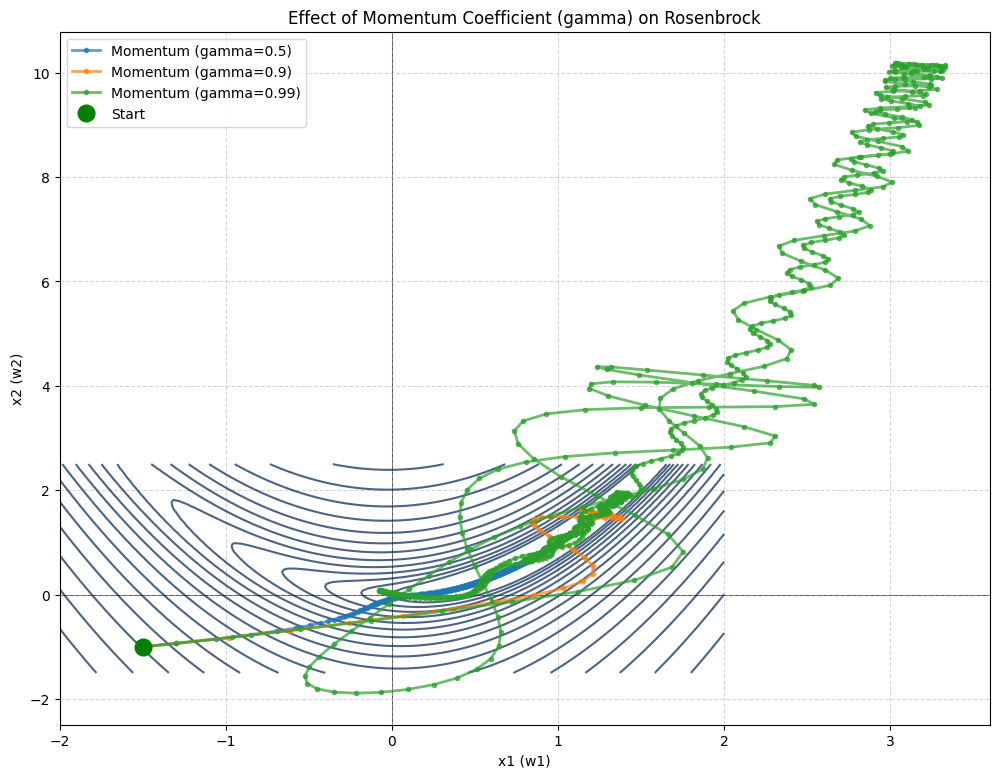

In [8]:
# --- 1. Define Optimizers with Different Gamma Values ---
gammas = [0.5, 0.9, 0.99]
start_point_compare = np.array([-1.5, -1.0])

histories_momentum = {}
print("Testing different momentum values:\n")

for gamma in gammas:
    print(f"Running Momentum GD with gamma={gamma}...")
    mgd = MomentumGradientDescent(alpha=0.001, gamma=gamma)
    sol, history = mgd.optimize(
        x=start_point_compare.copy(),
        func_callback=Rosenbrock,
        grad_func_callback=Rosenbrock.grad,
        is_plot=True
    )
    histories_momentum[f"Momentum (gamma={gamma})"] = history
    print(f"  Converged in {mgd.num_iter} iterations\n")

# --- 2. Plot Comparison ---
plot_contour_comparison(
    func_callable=Rosenbrock,
    histories=histories_momentum,
    x_range=(-2, 2),
    y_range=(-1.5, 2.5),
    title="Effect of Momentum Coefficient (gamma) on Rosenbrock"
)

## 5. Summary

### Key Observations:

**Momentum Gradient Descent:**
- Accumulates past gradients in a velocity term
- Helps smooth out oscillations
- Builds speed in consistent directions
- Can overshoot when momentum is too high

**Nesterov Accelerated Gradient:**
- Uses "look-ahead" gradient computation
- Often converges faster than standard momentum
- Better at making corrections before overshooting
- More responsive to changes in gradient direction

**Momentum Parameter (gamma):**
- Higher gamma (e.g., 0.9-0.99): More momentum, faster in consistent directions but can overshoot
- Lower gamma (e.g., 0.5): Less momentum, more responsive but slower convergence
- Typical values: 0.9 for most applications